# In this file:

We identify the channels of interest, together with their date of interest.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import copy
import csv

from src.data.dataloader_functions import *
from src.utils.results_utils import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Preprocess the data

In [2]:
# Run the shell script
import subprocess

# Path to the shell script
script_path = "./src/scripts/preprocessing_pipeline.sh"

# Run the shell script
try:
    result = subprocess.run(
        ["bash", script_path],  # Specify the shell script and interpreter
        check=True,             # Raise an error if the command fails
        text=True,              # Capture output as a string
        capture_output=True     # Capture stdout and stderr
    )
    # Print the output
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print("Error running the script:")
    print(e.stderr)

Activating the virtual environment
Running the preprocessing pipeline
Perform data preprocessing
Loaded 18872499 rows
Loading data from '/Users/nicolas/Desktop/MA1/ADA/ADA_milestone2/ada-2024-project-ooohfada/data/yt_metadata_helper.feather'...
Preprocessing...
Preprocessing done:
Processed time series data updated in '/Users/nicolas/Desktop/MA1/ADA/ADA_milestone2/ada-2024-project-ooohfada/data/df_data_en_processed.tsv' in 521.02s
Perform BB data preprocessing
Loaded 18872499 rows
Loading data from '/Users/nicolas/Desktop/MA1/ADA/ADA_milestone2/ada-2024-project-ooohfada/data/yt_metadata_helper.feather'...
Filtering...
Preprocessing...
Filtering and preprocessing done:
                              category         views  ...  like_count  dislike_count
channel                  week                         ...                           
UC-lHJZR3Gqxm24_Vd_AJ5Yw 93     Gaming  1.357761e+10  ...   1892943.0        51248.0
                         94     Gaming  1.368959e+10  ...   2018614.

## Load the data:

In [2]:
# Load the original data for the index
original_data = load_processed_data(verbose = True)

Loading data in chunks of 1000: 100%|█████████▉| 18592/18604.825 [01:13<00:00, 272.95it/s]/Users/nathangromb/opt/miniconda3/lib/python3.9/site-packages/tqdm/std.py:524: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Loading data in chunks of 1000: 100%|██████████| 18605/18604.825 [01:13<00:00, 253.27it/s]


Loaded 18604824 rows


Re-compute the rolling growth rate and store it to file

/!\ Note: Running the following cell is very time-consuming and requires around 16GB of memory. Run it only if you don't have the file `df_with_rgr.csv` in the `data` folder.

In [4]:
ROLLING_WINDOW = 20  # Set the rolling window for the growth rate, (5 months by default, could be changed in the future)

# Initialize an empty DataFrame to store the results
result = pd.DataFrame()

# Iterate over each group with a progress bar
for name, group in tqdm(original_data.groupby('channel'), desc="Processing channels"):
    group['rolling_growth_rate'] = group['delta_subs'].rolling(ROLLING_WINDOW, min_periods=ROLLING_WINDOW).mean()
    result = pd.concat([result, group])

result['growth_diff'] = result['delta_subs'] - result['rolling_growth_rate']

result.to_csv('data/df_with_rgr_new.tsv', sep='\t', index=True)

Processing channels: 100%|██████████| 133516/133516 [5:54:25<00:00,  6.28it/s]  


In [ ]:
ROLLING_WINDOW = 50  # Set the rolling window for the growth rate, (5 months by default, could be changed in the future)

# Initialize an empty DataFrame to store the results
resul_bist = pd.DataFrame()

# Iterate over each group with a progress bar
for name, group in tqdm(original_data.groupby('channel'), desc="Processing channels"):
    group['rolling_growth_rate_bis'] = group['delta_subs'].rolling(ROLLING_WINDOW, min_periods=ROLLING_WINDOW).mean()
    result = pd.concat([result, group])

result['growth_diff_bis'] = result['delta_subs'] - result['rolling_growth_rate']

result.to_csv('data/df_with_rgr_new_bis.tsv', sep='\t', index=True)

Load the data with the rolling growth rate

In [3]:
# Load the data with rolling growth rate
df_with_rgr_new = pd.read_csv('data/df_with_rgr_new.tsv', sep='\t')
df_with_rgr_new.set_index(['channel', 'week'], inplace=True)

In [4]:
# Detection of period where growth_rate < rolling_growth_rate
df_with_rgr_new['decline_event_detected'] = df_with_rgr_new['growth_diff'] < 0
df_with_rgr_new.head(25)

category          views  delta_views  \
channel                  week                                                
UC--24Q3_ZQeFmgJE-Um5QZQ 82    Travel & Events   62524.500000          NaN   
                         83    Travel & Events   67600.250000  5075.750000   
                         84    Travel & Events   69982.000000  2381.750000   
                         85    Travel & Events   72663.125000  2681.125000   
                         86    Travel & Events   75093.000000  2429.875000   
                         87    Travel & Events   77511.500000  2418.500000   
                         88    Travel & Events   80095.000000  2583.500000   
                         89    Travel & Events   82434.750000  2339.750000   
                         90    Travel & Events   84621.500000  2186.750000   
                         91    Travel & Events   86963.500000  2342.000000   
                         92    Travel & Events   89498.500000  2535.000000   
                         93    Travel & Events   91871.375000  2372.875000   
                         94    Travel & Events   96850.927461  4979.552461   
                         95    Travel & Events   98694.916667  1843.989206   
                         96    Travel & Events  100752.734375  2057.817708   
                         97    Travel & Events  103355.203125  2602.468750   
                         98    Travel & Events  105603.218750  2248.015625   
                         99    Travel & Events  107370.328125  1767.109375   
                         100   Travel & Events  110134.979167  2764.651042   
                         101   Travel & Events  112406.479167  2271.500000   
                         102   Travel & Events  115317.276042  2910.796875   
                         103   Travel & Events  118048.682292  2731.406250   
                         104   Travel & Events  122239.276042  4190.593750   
                         105   Travel & Events  131050.723958  8811.447917   
                         106   Travel & Events  135258.307292  4207.583333   

                                      subs  delta_subs  videos  delta_videos  \
channel                  week                                                  
UC--24Q3_ZQeFmgJE-Um5QZQ 82    1466.000000         NaN      29           NaN   
                         83    1508.625000   42.625000      30           1.0   
                         84    1530.750000   22.125000      31           1.0   
                         85    1558.625000   27.875000      32           1.0   
                         86    1591.000000   32.375000      33           1.0   
                         87    1621.625000   30.625000      34           1.0   
                         88    1650.750000   29.125000      35           1.0   
                         89    1667.125000   16.375000      36           1.0   
                         90    1679.000000   11.875000      37           1.0   
                         91    1701.375000   22.375000      38           1.0   
                         92    1734.750000   33.375000      38           0.0   
                         93    1760.875000   26.125000      39           1.0   
                         94    1800.150259   39.275259      41           2.0   
                         95    1811.192708   11.042449      42           1.0   
                         96    1825.156250   13.963542      43           1.0   
                         97    1847.338542   22.182292      44           1.0   
                         98    1868.546875   21.208333      45           1.0   
                         99    1879.958333   11.411458      46           1.0   
                         100   1888.036458    8.078125      47           1.0   
                         101   1902.911458   14.875000      48           1.0   
                         102   1938.661458   35.750000      49           1.0   
                         103   1973.791667   35.130208      50           1.0   
           

In [5]:
df_with_rgr_grouped = df_with_rgr_new.reset_index().groupby('channel')

print(f'Number of channels : {len(df_with_rgr_grouped.groups.keys())}')

Number of channels : 133516


In [6]:
df_with_rgr_grouped.get_group('UC-lHJZR3Gqxm24_Vd_AJ5Yw')

,channel,week,category,views,delta_views,subs,delta_subs,videos,delta_videos,activity,view_count,like_count,dislike_count,rolling_growth_rate,growth_diff,decline_event_detected
222663,UC-lHJZR3Gqxm24_Vd_AJ5Yw,93,Gaming,1.357761e+10,NaN,4.861796e+07,NaN,2906,NaN,14,45210757.0,1892943.0,51248.0,NaN,NaN,False
222664,UC-lHJZR3Gqxm24_Vd_AJ5Yw,94,Gaming,1.368959e+10,1.119836e+08,4.897182e+07,353856.680699,2919,13.0,15,40885232.0,2018614.0,35580.0,NaN,NaN,False
222665,UC-lHJZR3Gqxm24_Vd_AJ5Yw,95,Gaming,1.373594e+10,4.635159e+07,4.909397e+07,122152.626592,2926,7.0,15,27707359.0,1390650.0,22598.0,NaN,NaN,False
222666,UC-lHJZR3Gqxm24_Vd_AJ5Yw,96,Gaming,1.376195e+10,2.600902e+07,4.917638e+07,82404.010417,2932,6.0,14,25489724.0,1261334.0,38704.0,NaN,NaN,False
222667,UC-lHJZR3Gqxm24_Vd_AJ5Yw,97,Gaming,1.378603e+10,2.407718e+07,4.925474e+07,78360.625000,2934,2.0,9,10034755.0,514876.0,19313.0,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222810,UC-lHJZR3Gqxm24_Vd_AJ5Yw,243,Gaming,2.316604e+10,1.237398e+08,1.008078e+08,395694.250000,3909,7.0,16,47537894.0,3618933.0,42940.0,330238.08750,65456.16250,False
222811,UC-lHJZR3Gqxm24_Vd_AJ5Yw,244,Gaming,2.327098e+10,1.049338e+08,1.010909e+08,283079.500000,3914,5.0,14,99710511.0,7169424.0,138574.0,319666.00000,-36586.50000,True
222812,UC-lHJZR3Gqxm24_Vd_AJ5Yw,245,Gaming,2.337946e+10,1.084825e+08,1.010624e+08,-28475.875000,3921,7.0,14,61062493.0,3797080.0,43084.0,297805.65625,-326281.53125,True
222813,UC-lHJZR3Gqxm24_Vd_AJ5Yw,246,Gaming,2.347540e+10,9.593404e+07,1.010000e+08,-62395.875000,3928,7.0,16,50440884.0,3058171.0,39964.0,277660.20000,-340056.07500,True


In [7]:
# Create a map that contains for each entry: the id of the channel, and the starting week and end week of each decline event
decline_events = {}

# For loop to detect the starting and ending week of the decline event
for channel in tqdm(df_with_rgr_grouped.groups.keys(), desc="Processing channels"):
    channel_data = df_with_rgr_grouped.get_group(channel)

    # Identify indices where decline has started and ended
    for i in range(1, len(channel_data)):
        if channel_data['decline_event_detected'].iloc[i] and not channel_data['decline_event_detected'].iloc[i-1]:
            # Add the starting week of the decline event
            if channel not in decline_events:
                decline_events[channel] = []
            if channel == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw':
                print(f'Channel {channel} has a decline event that starts.')
            decline_events[channel].append((channel_data['week'].iloc[i], None))
        if ((not channel_data['decline_event_detected'].iloc[i]) and channel_data['decline_event_detected'].iloc[i-1]):
            # Add the ending week of the decline event
            decline_events[channel][-1] = (decline_events[channel][-1][0], channel_data['week'].iloc[i])
            if channel == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw':
                    print(f'Channel {channel} has a decline event that ends.')


Processing channels:   1%|▏         | 1760/133516 [00:02<02:46, 791.73it/s]

Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that starts.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that ends.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that starts.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that ends.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that starts.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that ends.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that starts.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that ends.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that starts.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that ends.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that starts.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that ends.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that starts.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that ends.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that starts.
Channel UC-lHJZR3Gqxm24_

Processing channels: 100%|██████████| 133516/133516 [02:46<00:00, 802.97it/s]


In [8]:
print(f'Total number of decline events found: {sum([len(v) for v in decline_events.values()])}')

Total number of decline events found: 1491324


In [9]:
print(decline_events['UC-lHJZR3Gqxm24_Vd_AJ5Yw'])

[(113, 127), (130, 131), (137, 146), (147, 151), (162, 179), (194, 197), (215, 218), (222, 241), (244, None)]


In [10]:
# Remove only the events (tuples) with None as the second element
decline_events_no_None = {k: [x for x in v if x[1] is not None] for k, v in decline_events.items()}

In [11]:
print(f'There are {sum([len(v) for v in decline_events_no_None.values()])} decline events with a start and end week.')

There are 1401275 decline events with a start and end week.


In [12]:
print(decline_events_no_None['UC-lHJZR3Gqxm24_Vd_AJ5Yw'])

[(113, 127), (130, 131), (137, 146), (147, 151), (162, 179), (194, 197), (215, 218), (222, 241)]


In [13]:
# Add the duration of the decline event for each decline event for each channel (created from a deep copy of the original decline events)
decline_events_with_duration = copy.deepcopy(decline_events_no_None)

for channel in decline_events_with_duration:
    for i in range(len(decline_events_with_duration[channel])):
        decline_events_with_duration[channel][i] = ((decline_events_with_duration[channel][i][0], decline_events_with_duration[channel][i][1]), decline_events_with_duration[channel][i][1] - decline_events_with_duration[channel][i][0])

In [14]:
decline_events_with_duration

{'UC--24Q3_ZQeFmgJE-Um5QZQ': [((105, 107), 2),
  ((108, 110), 2),
  ((114, 126), 12),
  ((127, 131), 4),
  ((135, 137), 2),
  ((148, 166), 18),
  ((168, 170), 2),
  ((174, 179), 5),
  ((184, 197), 13),
  ((199, 206), 7),
  ((209, 221), 12),
  ((223, 224), 1)],
 'UC--2EbuIuBOGgGqPiJxi3rg': [((108, 111), 3),
  ((112, 113), 1),
  ((140, 146), 6),
  ((147, 162), 15),
  ((163, 165), 2),
  ((168, 172), 4),
  ((173, 182), 9),
  ((185, 198), 13),
  ((200, 204), 4),
  ((205, 206), 1),
  ((209, 210), 1),
  ((219, 227), 8),
  ((230, 240), 10),
  ((242, 246), 4)],
 'UC--3c8RqSfAqYBdDjIG3UNA': [((236, 241), 5)],
 'UC--3ozenTzry39-xMqAPQlw': [((111, 114), 3),
  ((117, 118), 1),
  ((121, 146), 25),
  ((147, 148), 1),
  ((151, 154), 3),
  ((158, 166), 8),
  ((169, 186), 17),
  ((187, 192), 5),
  ((193, 195), 2),
  ((197, 198), 1),
  ((199, 200), 1),
  ((202, 203), 1),
  ((204, 207), 3),
  ((210, 228), 18),
  ((230, 236), 6)],
 'UC--6E6EpybocdaNlPhvK_9A': [((103, 109), 6),
  ((116, 120), 4),
  ((124, 1

In [15]:
# Filter out the decline events that are shorter than the minimum duration

DECLINE_MIN_DURATION = 8 # Set the minimum duration of a detected decline event to be considered as an effective decline event
de_filtered_on_duration = {k: [x for x in v if x[1] >= DECLINE_MIN_DURATION] for k, v in decline_events_with_duration.items()}

In [16]:
print(f'There are {sum([len(v) for v in de_filtered_on_duration.values()])} decline events with duration of at least {DECLINE_MIN_DURATION} weeks.')

There are 379697 decline events with duration of at least 8 weeks.


In [17]:
# Compute the growth diff percentage
df_with_rgr_final = df_with_rgr_new
df_with_rgr_final['growth_diff_percentage'] = (df_with_rgr_final['growth_diff'] / df_with_rgr_final['rolling_growth_rate']) * 100
df_with_rgr_final.head()

category      views  delta_views  \
channel                  week                                            
UC--24Q3_ZQeFmgJE-Um5QZQ 82    Travel & Events  62524.500          NaN   
                         83    Travel & Events  67600.250     5075.750   
                         84    Travel & Events  69982.000     2381.750   
                         85    Travel & Events  72663.125     2681.125   
                         86    Travel & Events  75093.000     2429.875   

                                   subs  delta_subs  videos  delta_videos  \
channel                  week                                               
UC--24Q3_ZQeFmgJE-Um5QZQ 82    1466.000         NaN      29           NaN   
                         83    1508.625      42.625      30           1.0   
                         84    1530.750      22.125      31           1.0   
                         85    1558.625      27.875      32           1.0   
                         86    1591.000      32.375      33           1.0   

                               activity  view_count  like_count  \
channel                  week                                     
UC--24Q3_ZQeFmgJE-Um5QZQ 82           1      5849.0       222.0   
                         83           2      5336.0       204.0   
                         84           2      5727.0       232.0   
                         85           2     19214.0       318.0   
                         86           2      6949.0       234.0   

                               dislike_count  rolling_growth_rate  \
channel                  week                                       
UC--24Q3_ZQeFmgJE-Um5QZQ 82              1.0                  NaN   
                         83              1.0                  NaN   
                         84              1.0                  NaN   
                         85              7.0                  NaN   
                         86              1.0                  NaN   

                               growth_diff  decline_event_detected  \
channel                  week                                        
UC--24Q3_ZQeFmgJE-Um5QZQ 82            NaN                   False   
                         83            NaN                   False   
                         84            NaN                   False   
                         85            NaN                   False   
                         86            NaN                   False   

                               growth_diff_percentage  
channel                  week                          
UC--24Q3_ZQeFmgJE-Um5QZQ 82                       NaN  
                         83                       NaN  
                         84                       NaN  
                         85                       NaN  
                         86                       NaN

In [18]:
df_with_rgr_grouped_final = df_with_rgr_final.reset_index().groupby('channel')

In [19]:
# From the decline events filtered out because of a too short duration, we check if the event should still be included in the list of decline events, 
# because it is too intense (i.e. the minimum growth difference is below a certain threshold)

DECLINE_MIN_GROWTH_DIFF_PERCENTAGE = - 80 # Set the minimum magnitude of the growth difference to be considered as an effective decline event

# For each channel, for each event:
# We keep the event only if the miimum growth difference during the period starting from the first week of the event to the last week of the event is less than the threshold
de_filtered_on_growth_diff = {}

for channel in tqdm(df_with_rgr_grouped_final.groups.keys(), desc="Processing channels"):
    channel_data = df_with_rgr_grouped_final.get_group(channel)
    for event in decline_events_with_duration.get(channel, []):
        start_week = event[0][0]
        end_week = event[0][1]
        min_growth_diff = channel_data.loc[(channel_data['week'] >= start_week) & (channel_data['week'] <= end_week)]['growth_diff_percentage'].min()
        if min_growth_diff < DECLINE_MIN_GROWTH_DIFF_PERCENTAGE:
            if channel not in de_filtered_on_growth_diff:
                de_filtered_on_growth_diff[channel] = []
            de_filtered_on_growth_diff[channel].append(event)

Processing channels: 100%|██████████| 133516/133516 [03:16<00:00, 679.93it/s]


In [20]:
print(f'{sum([len(v) for v in de_filtered_on_growth_diff.values()])} decline events were found using the growth difference threshold.')

231602 decline events were found using the growth difference threshold.


In [21]:
# From the decline events filtered on growth difference, we remove the events that are shorter than 2 weeks to avoid outliers

ANTI_OUTLIERS_MIN_DURATION = 8
de_filtered_on_growth_diff_no_outliers = {k: [x for x in v if x[1] >= ANTI_OUTLIERS_MIN_DURATION] for k, v in de_filtered_on_growth_diff.items()}

In [22]:
print(f'There are {sum([len(v) for v in de_filtered_on_growth_diff_no_outliers.values()])} decline events (based on growth rate) with duration of at least {ANTI_OUTLIERS_MIN_DURATION} weeks.')

There are 121998 decline events (based on growth rate) with duration of at least 8 weeks.


In [23]:
# Merge the decline events filtered on duration (de_filtered_on_duration) and growth difference (de_filtered_on_growth_diff_no_outliers) in one dictionary
decline_events_final = {k: de_filtered_on_duration.get(k, []) + de_filtered_on_growth_diff_no_outliers.get(k, []) for k in set(de_filtered_on_duration) | set(de_filtered_on_growth_diff_no_outliers)}
decline_events_final = {k: de_filtered_on_growth_diff_no_outliers.get(k, []) for k in set(de_filtered_on_growth_diff_no_outliers)}

print(f'There are {sum([len(v) for v in decline_events_final.values()])} decline events in total.')

There are 121998 decline events in total.


In [24]:
df_with_rgr_new.loc[('UC-lHJZR3Gqxm24_Vd_AJ5Yw', 95)]

category                              Gaming
views                     13735941803.151039
delta_views                   46351585.20285
subs                         49093973.932292
delta_subs                     122152.626592
videos                                  2926
delta_videos                             7.0
activity                                  15
view_count                        27707359.0
like_count                         1390650.0
dislike_count                        22598.0
rolling_growth_rate                      NaN
growth_diff                              NaN
decline_event_detected                 False
growth_diff_percentage                   NaN
Name: (UC-lHJZR3Gqxm24_Vd_AJ5Yw, 95), dtype: object

In [25]:
# Sort the decline events by starting week
decline_events_final_sorted = {k: sorted(v, key=lambda x: x[0][0]) for k, v in decline_events_final.items()}
decline_events_final_sorted

{'UCVF3CWEIvIsS5IAxFdO1AqQ': [((159, 191), 32)],
 'UCH9_JtHvtfg-miPhUvEqDXg': [((150, 158), 8),
  ((159, 170), 11),
  ((178, 192), 14),
  ((202, 214), 12)],
 'UCXVL9MmJ9d2T3akhQCG-_xQ': [((180, 207), 27)],
 'UCb02ANOm7wXi4fWBy8SkoGw': [((141, 161), 20), ((229, 239), 10)],
 'UC1VUYhx4uOw9meAl9M5YMfw': [((107, 129), 22),
  ((161, 178), 17),
  ((207, 215), 8)],
 'UCjgRwOQ6ImQ2HUZCc8PBy3A': [((237, 247), 10)],
 'UC93qQNy7PLcVjCKWj5UuPWg': [((136, 172), 36), ((199, 211), 12)],
 'UCuNkZpXgvjYk-PWcyGm-smg': [((171, 181), 10)],
 'UCVrYrjXtAIgBbVN1i_FiGtw': [((170, 197), 27)],
 'UCKzn33KKBEBYI7J13SIZ0Qg': [((169, 192), 23)],
 'UCOoFUsgQGjkDh9krcq4yn5A': [((90, 100), 10),
  ((103, 123), 20),
  ((142, 162), 20),
  ((178, 187), 9),
  ((199, 212), 13),
  ((224, 239), 15)],
 'UCtr2VqYDR7mx0Q15jOfK1vg': [((163, 186), 23)],
 'UC5JcVoT2kuz-iz4YLkyPrUQ': [((125, 187), 62),
  ((213, 223), 10),
  ((238, 247), 9)],
 'UCQ97Xu0vHj6dYFcEw4hdDow': [((199, 208), 9)],
 'UC9iHcD8v9l3yCId0aHsWvYA': [((180, 198), 1

In [26]:
print(f'Number of channels with decline events detected: {len(decline_events_final_sorted)}')
print(f'Number of decline events detected: {sum([len(v) for v in decline_events_final_sorted.values()])}')

Number of channels with decline events detected: 74788
Number of decline events detected: 121998


In [27]:
# Check the number of decline events detected for a specific channel
channel = 'UC-lHJZR3Gqxm24_Vd_AJ5Yw'
if channel in decline_events_final_sorted:
    nb_events = len(decline_events_final_sorted.get(channel))
else:
    nb_events = 0
print(f'Number of decline events detected for channel {channel}: {nb_events}')

Number of decline events detected for channel UC-lHJZR3Gqxm24_Vd_AJ5Yw: 1


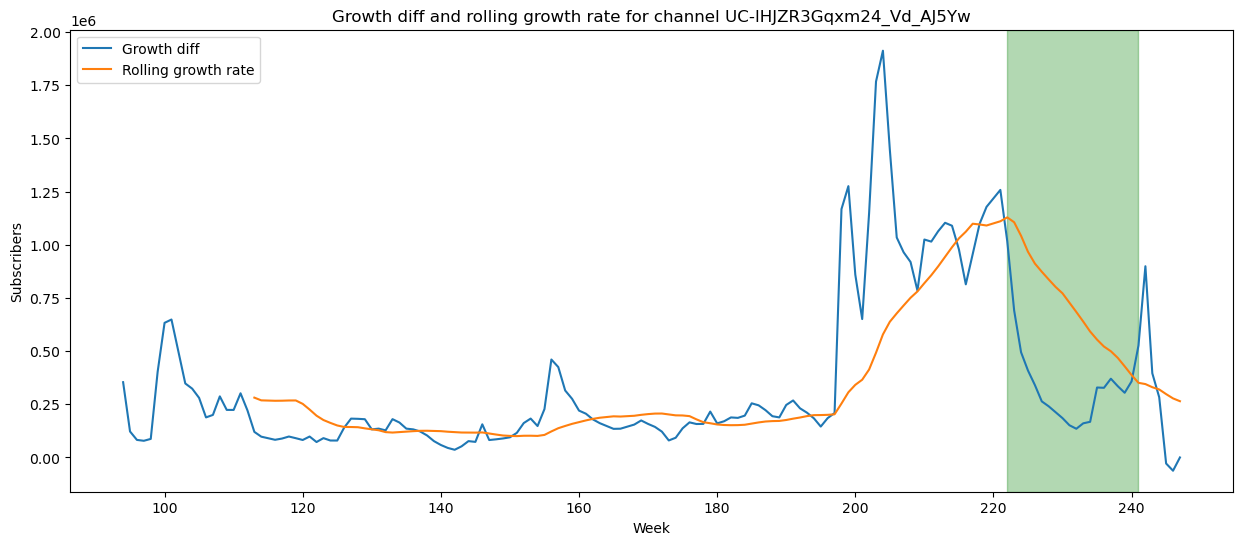

In [28]:
# For one channel, plot the growth difference and the rolling growth rate, and highlight the decline events from decline_events_final_sorted

channel = 'UC-lHJZR3Gqxm24_Vd_AJ5Yw'
channel_data = df_with_rgr_grouped_final.get_group(channel)

plt.figure(figsize=(15, 6))
plt.plot(channel_data['week'], channel_data['delta_subs'], label='Growth diff')
plt.plot(channel_data['week'], channel_data['rolling_growth_rate'], label='Rolling growth rate')
plt.title(f'Growth diff and rolling growth rate for channel {channel}')
plt.xlabel('Week')
plt.ylabel('Subscribers')
plt.legend()

for event in decline_events_final_sorted.get(channel, []):
    plt.axvspan(event[0][0], event[0][1], color='green', alpha=0.3)
    
plt.show()

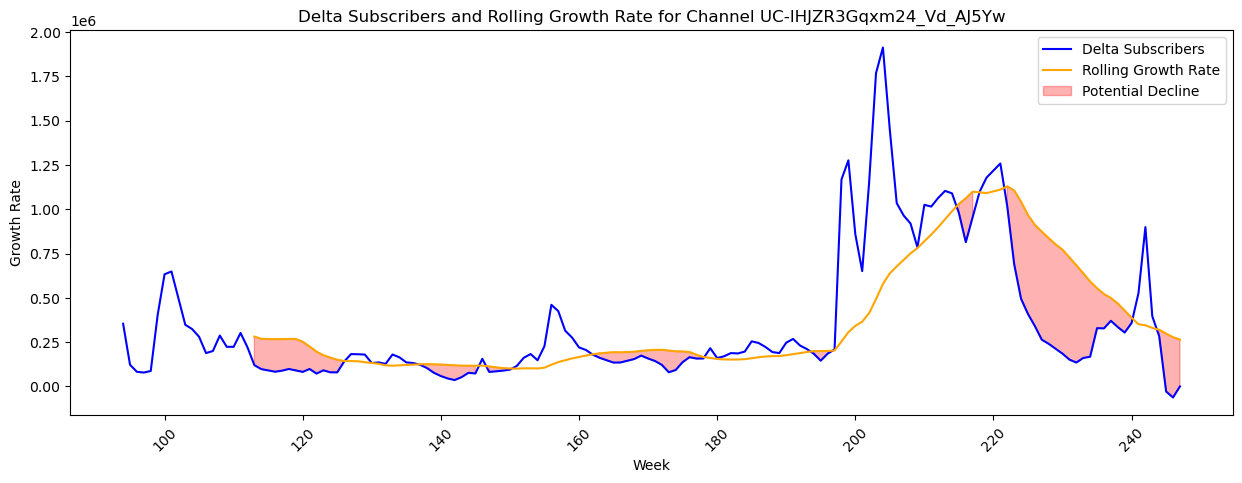

In [29]:
plot_rolling_growth_rate2('UC-lHJZR3Gqxm24_Vd_AJ5Yw', df_with_rgr_final)

In [30]:
# Write to CSV file
with open('decline_events_complete.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    # Write header
    writer.writerow(["Channel", "Event", "Duration"])
    
    # Write rows
    for channel, events in decline_events_final_sorted.items():
        for event, end_week in events:
            writer.writerow([channel, event, end_week])

In [31]:
decline_events = df_with_rgr_new[df_with_rgr_new['decline_event_detected']].drop(columns=['decline_event_detected'])
nb_channels_with_decline = decline_events.index.get_level_values('channel').nunique()  
print(f"Number of channels with decline detected: {nb_channels_with_decline}")

Number of channels with decline detected: 131395


In [32]:
decline_events.head()

category          views  delta_views  \
channel                  week                                                
UC--24Q3_ZQeFmgJE-Um5QZQ 105   Travel & Events  131050.723958  8811.447917   
                         106   Travel & Events  135258.307292  4207.583333   
                         108   Travel & Events  134566.348958  2978.375000   
                         109   Travel & Events  136964.723958  2398.375000   
                         114   Travel & Events  157230.708333  3331.468750   

                                      subs  delta_subs  videos  delta_videos  \
channel                  week                                                  
UC--24Q3_ZQeFmgJE-Um5QZQ 105   2013.927083   15.671875      53           1.0   
                         106   2031.723958   17.796875      54           1.0   
                         108   2068.916667   14.755208      56           1.0   
                         109   2082.916667   14.000000      57           1.0   
                         114   2294.286458   19.421875      62           1.0   

                               activity  view_count  like_count  \
channel                  week                                     
UC--24Q3_ZQeFmgJE-Um5QZQ 105          3      4527.0       261.0   
                         106          2      4456.0       256.0   
                         108          2      4223.0       274.0   
                         109          2      5240.0       300.0   
                         114          2      4704.0       252.0   

                               dislike_count  rolling_growth_rate  \
channel                  week                                       
UC--24Q3_ZQeFmgJE-Um5QZQ 105             4.0            22.765104   
                         106             2.0            22.036198   
                         108             0.0            20.908333   
                         109             2.0            20.789583   
                         114             2.0            24.706810   

                               growth_diff  growth_diff_percentage  
channel                  week                                       
UC--24Q3_ZQeFmgJE-Um5QZQ 105     -7.093229              -31.158343  
                         106     -4.239323              -19.237996  
                         108     -6.153125              -29.429055  
                         109     -6.789583              -32.658583  
                         114     -5.284935              -21.390600

In [33]:
decline_events['growth_diff_percentage'] = (decline_events['growth_diff'] / decline_events['rolling_growth_rate']) * 100
decline_events.head()

category          views  delta_views  \
channel                  week                                                
UC--24Q3_ZQeFmgJE-Um5QZQ 105   Travel & Events  131050.723958  8811.447917   
                         106   Travel & Events  135258.307292  4207.583333   
                         108   Travel & Events  134566.348958  2978.375000   
                         109   Travel & Events  136964.723958  2398.375000   
                         114   Travel & Events  157230.708333  3331.468750   

                                      subs  delta_subs  videos  delta_videos  \
channel                  week                                                  
UC--24Q3_ZQeFmgJE-Um5QZQ 105   2013.927083   15.671875      53           1.0   
                         106   2031.723958   17.796875      54           1.0   
                         108   2068.916667   14.755208      56           1.0   
                         109   2082.916667   14.000000      57           1.0   
                         114   2294.286458   19.421875      62           1.0   

                               activity  view_count  like_count  \
channel                  week                                     
UC--24Q3_ZQeFmgJE-Um5QZQ 105          3      4527.0       261.0   
                         106          2      4456.0       256.0   
                         108          2      4223.0       274.0   
                         109          2      5240.0       300.0   
                         114          2      4704.0       252.0   

                               dislike_count  rolling_growth_rate  \
channel                  week                                       
UC--24Q3_ZQeFmgJE-Um5QZQ 105             4.0            22.765104   
                         106             2.0            22.036198   
                         108             0.0            20.908333   
                         109             2.0            20.789583   
                         114             2.0            24.706810   

                               growth_diff  growth_diff_percentage  
channel                  week                                       
UC--24Q3_ZQeFmgJE-Um5QZQ 105     -7.093229              -31.158343  
                         106     -4.239323              -19.237996  
                         108     -6.153125              -29.429055  
                         109     -6.789583              -32.658583  
                         114     -5.284935              -21.390600

In [34]:
decline_events_grouped = decline_events.reset_index().groupby('channel')

In [35]:
# From the decline events filtered out because of a too short duration, we check if the event should still be included in the list of decline events, 
# because it is too intense (i.e. the minimum growth difference is below a certain threshold)

DECLINE_MIN_GROWTH_DIFF_PERCENTAGE = - 80 # Set the minimum magnitude of the growth difference to be considered as an effective decline event

# For each channel, for each event:
# We keep the event only if the miimum growth difference during the period starting from the first week of the event to the last week of the event is less than the threshold
declined_filtered_on_growth_diff = {}

for channel in tqdm(decline_events_grouped.groups.keys(), desc="Processing channels"):
    channel_data = decline_events_grouped.get_group(channel)
    for event in decline_events_with_duration.get(channel, []):
        start_week = event[0][0]
        end_week = event[0][1]
        min_growth_diff = channel_data.loc[(channel_data['week'] >= start_week) & (channel_data['week'] <= end_week)]['growth_diff_percentage'].min()
        if min_growth_diff < DECLINE_MIN_GROWTH_DIFF_PERCENTAGE:
            if channel not in declined_filtered_on_growth_diff:
                declined_filtered_on_growth_diff[channel] = []
            declined_filtered_on_growth_diff[channel].append(event)

Processing channels: 100%|██████████| 131395/131395 [03:32<00:00, 618.57it/s]


In [36]:
# i want to print the number of channels in declined_filtered_on_growth_diff
print(f'Number of channels with decline detected: {len(declined_filtered_on_growth_diff)}')

Number of channels with decline detected: 74311


In [121]:
decline_events_filtered_on_subs = decline_events[decline_events['subs'] > 1e6].copy()
nb_channels_with_decline_filtered_on_subs = decline_events_filtered_on_subs.index.get_level_values('channel').nunique()
print(f"Number of channels with decline detected and more than 1M subscribers: {nb_channels_with_decline_filtered_on_subs}")

Number of channels with decline detected and more than 1M subscribers: 6098


In [122]:
decline_events_filtered_on_subs['growth_diff_percentage'] = (decline_events_filtered_on_subs['growth_diff'] / decline_events_filtered_on_subs['rolling_growth_rate']) * 100
decline_events_filtered_on_subs.head()

category         views    delta_views  \
channel                  week                                         
UC--BMyA2X4a9PGAo3lTuopg 157    Comedy  1.537686e+08  865828.703125   
                         159    Comedy  1.553464e+08  633060.348958   
                         160    Comedy  1.558065e+08  460066.598958   
                         161    Comedy  1.562954e+08  488850.463542   
                         162    Comedy  1.568423e+08  546974.875000   

                                       subs   delta_subs  videos  \
channel                  week                                      
UC--BMyA2X4a9PGAo3lTuopg 157   1.062331e+06  4706.406250      33   
                         159   1.076044e+06  4735.937500      33   
                         160   1.078357e+06  2312.875000      33   
                         161   1.081719e+06  3361.989583      33   
                         162   1.086192e+06  4473.322917      33   

                               delta_videos  activity  view_count  like_count  \
channel                  week                                                   
UC--BMyA2X4a9PGAo3lTuopg 157            0.0         0         NaN         NaN   
                         159            0.0         0         NaN         NaN   
                         160            0.0         0         NaN         NaN   
                         161            0.0         0         NaN         NaN   
                         162            0.0         0         NaN         NaN   

                               dislike_count  rolling_growth_rate  \
channel                  week                                       
UC--BMyA2X4a9PGAo3lTuopg 157             NaN          5665.453125   
                         159             NaN          6187.677083   
                         160             NaN          6200.877083   
                         161             NaN          6297.095312   
                         162             NaN          6471.192708   

                               growth_diff  growth_diff_percentage  
channel                  week                                       
UC--BMyA2X4a9PGAo3lTuopg 157   -959.046875              -16.927982  
                         159  -1451.739583              -23.461786  
                         160  -3888.002083              -62.700841  
                         161  -2935.105729              -46.610470  
                         162  -1997.869792              -30.873285

In [123]:
decline_events_filtered_on_subs_grouped = decline_events_filtered_on_subs.reset_index().groupby('channel')

In [124]:
# From the decline events filtered out because of a too short duration, we check if the event should still be included in the list of decline events, 
# because it is too intense (i.e. the minimum growth difference is below a certain threshold)

DECLINE_MIN_GROWTH_DIFF_PERCENTAGE = - 80 # Set the minimum magnitude of the growth difference to be considered as an effective decline event

# For each channel, for each event:
# We keep the event only if the miimum growth difference during the period starting from the first week of the event to the last week of the event is less than the threshold
declined_filtered_on_subs_on_growth_diff = {}

for channel in tqdm(decline_events_filtered_on_subs_grouped.groups.keys(), desc="Processing channels"):
    channel_data = decline_events_filtered_on_subs_grouped.get_group(channel)
    for event in decline_events_with_duration.get(channel, []):
        start_week = event[0][0]
        end_week = event[0][1]
        min_growth_diff = channel_data.loc[(channel_data['week'] >= start_week) & (channel_data['week'] <= end_week)]['growth_diff_percentage'].min()
        if min_growth_diff < DECLINE_MIN_GROWTH_DIFF_PERCENTAGE:
            if channel not in declined_filtered_on_subs_on_growth_diff:
                declined_filtered_on_subs_on_growth_diff[channel] = []
            declined_filtered_on_subs_on_growth_diff[channel].append(event)

Processing channels: 100%|██████████| 6098/6098 [00:09<00:00, 647.94it/s]


In [125]:
# From the decline events filtered on growth difference, we remove the events that are shorter than 2 weeks to avoid outliers

ANTI_OUTLIERS_MIN_DURATION = 8
de_filtered_on_subs_on_growth_diff_no_outliers = {k: [x for x in v if x[1] >= ANTI_OUTLIERS_MIN_DURATION] for k, v in declined_filtered_on_subs_on_growth_diff.items()}

In [126]:
# remove events that have empty values
de_filtered_on_subs_on_growth_diff_no_outliers = {k: v for k, v in de_filtered_on_subs_on_growth_diff_no_outliers.items() if v}

In [127]:
print(f'Number of channels with decline detected: {len(de_filtered_on_subs_on_growth_diff_no_outliers)}')

Number of channels with decline detected: 2139


In [128]:
# i want to check if this channel is present is the dictionnary : 'UC-lHJZR3Gqxm24_Vd_AJ5Yw'
channel = 'UC-lHJZR3Gqxm24_Vd_AJ5Yw'
if channel in de_filtered_on_subs_on_growth_diff_no_outliers:
    nb_events = len(de_filtered_on_subs_on_growth_diff_no_outliers.get(channel))
else:
    nb_events = 0
print(f'Number of decline events detected for channel {channel}: {nb_events}')

Number of decline events detected for channel UC-lHJZR3Gqxm24_Vd_AJ5Yw: 1


In [129]:
data = load_bb_timeseries_processed(verbose=True)
bb_channels = data.index.get_level_values('channel').unique()

Loading data in chunks of 1000: 6it [00:00, 206.41it/s]                  

Loaded 5030 rows


In [130]:
nb_channels = 0
for channel in bb_channels:
    if channel in de_filtered_on_subs_on_growth_diff_no_outliers:
        nb_channels += 1
print(f'Number of channels with decline events detected: {nb_channels}')

Number of channels with decline events detected: 24
